<a href="https://colab.research.google.com/github/AKookani/Transormers_and_Finetuning_with_Supervised_Learning/blob/main/Workshop_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers

# part a
SECTION 1: Implementing a Transformer Model and Analyzing Temperature
Effects
- Implement a basic Transformer model from scratch using PyTorch.
- Generate outputs from your model by varying the temperature parameter. Use the following
temperature values:
  - T<1 (e.g., 0.5)
  - T=1
  - T>1 (e.g., 1.5 or 2)
- Analyze how changing the temperature affects the output

## import libraries


In [1]:
import re
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd

## prepare dataset

fisrt download the dataset from [this link](https://projectquest.ir/Transformers_for_Pattern_Recognition/hw3.txt)

In [2]:
!gdown 12U3zFsY2vuaiwKbDfR4V7M7tgynBHG7_

Downloading...
From: https://drive.google.com/uc?id=12U3zFsY2vuaiwKbDfR4V7M7tgynBHG7_
To: /content/dataset.txt
100% 3.23M/3.23M [00:00<00:00, 198MB/s]


then we should read the dataset

In [3]:
# read it in to inspect it
file_path = 'dataset.txt'
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("dataset length: ", len(text))

dataset length:  3204487



In this section, we should identify all unique Letters.

In [5]:
# Extract unique letters and sort them
letters = sorted(set(text))
letters_size = len(letters)

print(''.join(letters))
print(letters_size)


 !"'()*,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz﻿
79


In this section, we will perform three tasks:


1.   replace every hyphen in text with a space.
2.   define a regex pattern and use it to filter the text with the `re` library. With this pattern, you should be able to replace all characters except letters, numbers, dots, and newline characters (eg:* and !) with nothing.
3. detect lines and words in text

***Note: each line will end with a dot.***


In [6]:
# Replace hyphens with spaces
text = text.replace('-', ' ')

# Verify changes
print("Modified text sample: ", text[:500])  # Print the first 500 characters to check

# Define the regex pattern
pattern = r'[^a-zA-Z0-9.\n]'

# Replace all characters matching the pattern with nothing
filtered_text = re.sub(pattern, ' ', text)

# Verify the result
print("Filtered text sample: ", filtered_text[:500])  # Print the first 500 characters to check

# Detect lines and words
lines = filtered_text.splitlines()
words = filtered_text.split()

# Summary
print(f"Number of lines: {len(lines)}")
print(f"Number of words: {len(words)}")

# Samples
print("Sample lines:", lines[:5])
print("Sample words:", words[:10])

Modified text sample:  ﻿"Well, Prince, so Genoa and Lucca are now just family estates of the Buonapartes. But I warn you, if you don't tell me that this means war, if you still try to defend the infamies and horrors perpetrated by that Antichrist  I really believe he is Antichrist  I will have nothing more to do with you and you are no longer my friend, no longer my 'faithful slave,' as you call yourself! But how do you do? I see I have frightened you  sit down and tell me all the news."

It was in July, 1805, and the
Filtered text sample:    Well  Prince  so Genoa and Lucca are now just family estates of the Buonapartes. But I warn you  if you don t tell me that this means war  if you still try to defend the infamies and horrors perpetrated by that Antichrist  I really believe he is Antichrist  I will have nothing more to do with you and you are no longer my friend  no longer my  faithful slave   as you call yourself  But how do you do  I see I have frightened you  sit down and tell m

In [7]:
vocab_size = len(words)
print("Total no. of lines: ", len(lines))
print("Total unique words: ", len(words))

Total no. of lines:  25558
Total unique words:  572897


In this part, we create two dictionaries for mapping from words to integers and vice versa.

***Note: Here, rather than assigning a one-hot vector to each word, which can be sparse, we assign a single number to represent the word. This approach helps in better understanding the outputs.***


In [8]:
# Get the unique words
unique_words = sorted(set(words))  # Use `set` to get unique words and sort for consistent ordering

# Create a mapping from words to integers
word_to_int = {word: idx for idx, word in enumerate(unique_words)}

# Create a mapping from integers to words
int_to_word = {idx: word for word, idx in word_to_int.items()}

# Check the mappings
print("Sample word-to-integer mapping:", list(word_to_int.items())[::100])
print("Sample integer-to-word mapping:", list(int_to_word.items())[::100])

Sample word-to-integer mapping: [('.', 0), ('A', 100), ('Amuse', 200), ('Assessor', 300), ('Beauche', 400), ('Bonaparte', 500), ('Canal.', 600), ('Clever', 700), ('Cover', 800), ('Dimmler', 900), ('Dussek.', 1000), ('Eve', 1100), ('Firhoff', 1200), ('Gallop', 1300), ('Granddad', 1400), ('Herculean', 1500), ('Icon', 1600), ('Je', 1700), ('Knowing', 1800), ('Lead', 1900), ('MURAT', 2000), ('Matveich...', 2100), ('Moment', 2200), ('Natasha...', 2300), ('Odessa.', 2400), ('Pashette', 2500), ('Poleon', 2600), ('Pugachev', 2700), ('Rhipheus', 2800), ('Savelich.', 2900), ('Shan', 3000), ('Sophia', 3100), ('Suppert', 3200), ('Thirty', 3300), ('Tsarevich.', 3400), ('Various', 3500), ('Wagram.', 3600), ('Wussians', 3700), ('abasement.', 3800), ('acclaimed', 3900), ('actresses', 4000), ('advantageously', 4100), ('aghast', 4200), ('allegiance', 4300), ('ambulance', 4400), ('annihilated', 4500), ('apparent', 4600), ('arbitrariness', 4700), ('arsenal', 4800), ('associated', 4900), ('attitudes', 5000

In [9]:
#Mapping from words to integers and vice versa
##############################
# Your code here (~ 2 lines) #
##############################
#print(len(itos))

Now, we should create encoder and decoder:


*   encoder: take a string, output a list of integers
*   decoder: take a list of integers, output a string



In [10]:
# Encoder: String to list of integers
def encode(string):
    # Split the input string into words
    words = string.split()
    # Convert each word to its corresponding integer using the dictionary
    return [word_to_int[word] for word in words if word in word_to_int]

# Decoder: List of integers to string
def decode(integers):
    # Convert each integer back to its corresponding word using the dictionary
    return ' '.join(int_to_word[i] for i in integers if i in int_to_word)

# Example usage
sample_string = "Hello world This is a test"
encoded = encode(sample_string)
decoded = decode(encoded)

# Display the results
print("Original string:", sample_string)
print("Encoded:", encoded)
print("Decoded:", decoded)

Original string: Hello world This is a test
Encoded: [24435, 3301, 13845, 3788, 22221]
Decoded: world This is a test


In [11]:
##############################
# Your code here (~ 2 lines) #
##############################

print(encode("you are a teacher"))
print(decode(encode("you are a teacher")))

[24587, 4719, 3788, 22118]
you are a teacher


Now, we should convert our data to tensor and split it into training and validation sets.

In [12]:
# Encode the entire dataset
encoded_data = encode(filtered_text)

# Convert the encoded data to a PyTorch tensor
data_tensor = torch.tensor(encoded_data, dtype=torch.long)

In [13]:
print(data_tensor.shape, data_tensor.dtype)

torch.Size([572897]) torch.int64


In [14]:
##############################
# Your code here (~ 5 lines) #
##############################
#print(data.shape, data.dtype)

In [15]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data_tensor)) # first 90% will be train, rest val
train_data = data_tensor[:n]
val_data = data_tensor[n:]

In [16]:
train_data[50:55+1]

tensor([12413, 16034, 15522, 22519,  9289, 24323])

In [17]:
train_data[50:55+1]

tensor([12413, 16034, 15522, 22519,  9289, 24323])

## define our task

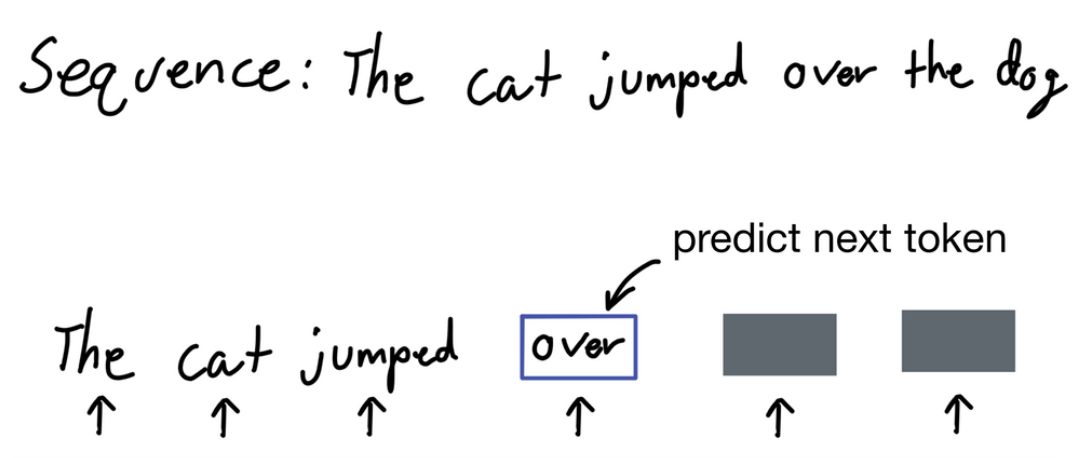

In [18]:
x = train_data[50:55]
y = train_data[51:56]
for t in range(5):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([12413]) the target: 16034
when input is tensor([12413, 16034]) the target: 15522
when input is tensor([12413, 16034, 15522]) the target: 22519
when input is tensor([12413, 16034, 15522, 22519]) the target: 9289
when input is tensor([12413, 16034, 15522, 22519,  9289]) the target: 24323


In [19]:
x = train_data[50:55]
y = train_data[51:56]
for t in range(5):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([12413]) the target: 16034
when input is tensor([12413, 16034]) the target: 15522
when input is tensor([12413, 16034, 15522]) the target: 22519
when input is tensor([12413, 16034, 15522, 22519]) the target: 9289
when input is tensor([12413, 16034, 15522, 22519,  9289]) the target: 24323


In [20]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
n_context = 8 # what is the maximum context length for predictions?
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_batch(split):
    # Use the appropriate dataset
    data = train_data if split == 'train' else val_data
    # Randomly choose starting indices for the batch
    indices = torch.randint(0, len(data) - n_context, (batch_size,))
    # Collect input sequences (x) and target sequences (y)
    x = torch.stack([data[i:i+n_context] for i in indices])
    y = torch.stack([data[i+1:i+n_context+1] for i in indices])
    return x.to(device), y.to(device)

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(n_context): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[22242, 18918, 18602, 22519, 14674,  6228, 22251,  2853],
        [ 6228,  4039, 11635, 16232, 13175,  8852,  8937,  4454],
        [10782, 16228, 24023,  4938, 22251,  8398, 15457,  4454],
        [24412, 20866, 19934, 23149,  7073,  4454, 22278, 22519]],
       device='cuda:0')
targets:
torch.Size([4, 8])
tensor([[18918, 18602, 22519, 14674,  6228, 22251,  2853, 22847],
        [ 4039, 11635, 16232, 13175,  8852,  8937,  4454,  3788],
        [16228, 24023,  4938, 22251,  8398, 15457,  4454, 20770],
        [20866, 19934, 23149,  7073,  4454, 22278, 22519, 15088]],
       device='cuda:0')
----
when input is [22242] the target: 18918
when input is [22242, 18918] the target: 18602
when input is [22242, 18918, 18602] the target: 22519
when input is [22242, 18918, 18602, 22519] the target: 14674
when input is [22242, 18918, 18602, 22519, 14674] the target: 6228
when input is [22242, 18918, 18602, 22519, 14674, 6228] the target: 22251
when input is [2224

## self-attention review

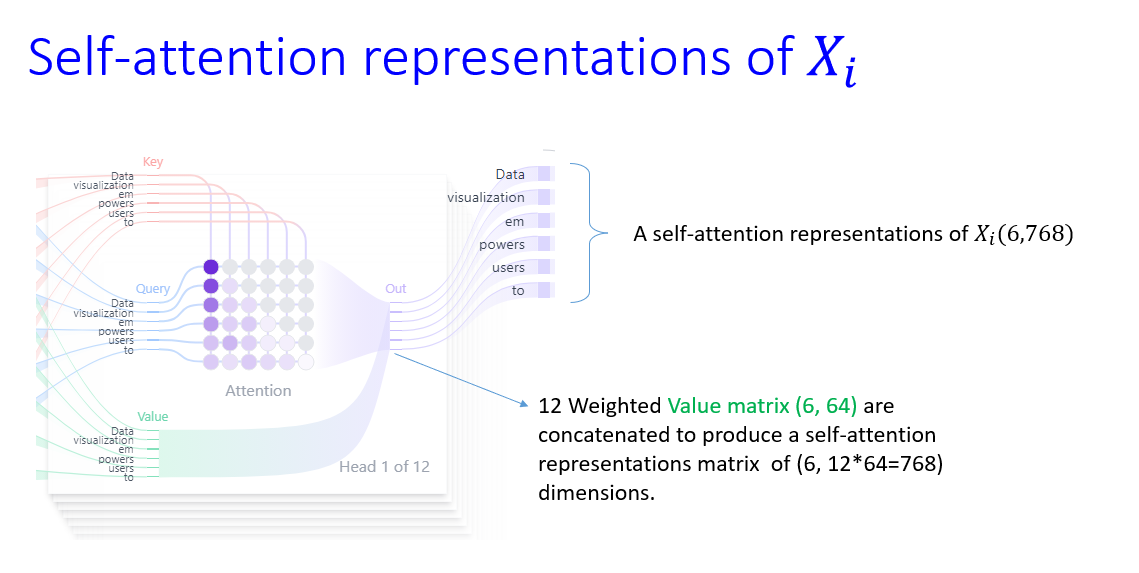

In [22]:
torch.manual_seed(1337)
batch_size, n_context, d_model = 1, 6, 768   # batch, n_context, d_model
x = torch.randn(batch_size, n_context, d_model)

print("x dimention is: ", x.shape)
# let's see a single Head perform self-attention
head_size = 64
number_of_heads = d_model//head_size

key = nn.Linear(d_model, head_size, bias=False)    # Maps input to key space
query = nn.Linear(d_model, head_size, bias=False)  # Maps input to query space
value = nn.Linear(d_model, head_size, bias=False)  # Maps input to value space
k = key(x)
q = query(x)

print("Query dimention (Head 1 of 12) is: ", q.shape)
print("Key dimention (Head 1 of 12) is: ", k.shape)

x dimention is:  torch.Size([1, 6, 768])
Query dimention (Head 1 of 12) is:  torch.Size([1, 6, 64])
Key dimention (Head 1 of 12) is:  torch.Size([1, 6, 64])


## Mask in attention review

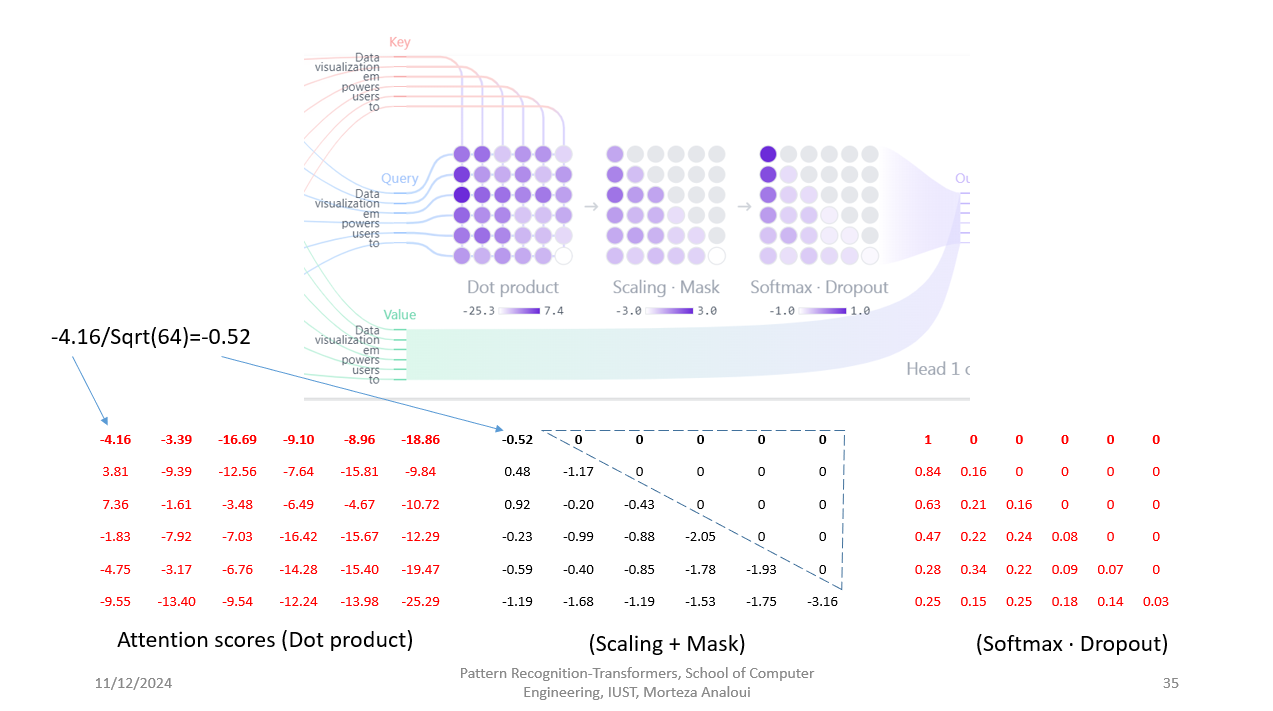

In [23]:
torch.manual_seed(1337)
batch_size, n_context, d_model = 1, 6, 768   # batch, n_context, d_model
x = torch.randn(batch_size, n_context, d_model)

print("x dimention is: ", x.shape)
# let's see a single Head perform self-attention
head_size = 64
number_of_heads = d_model // head_size  # Calculate the number of heads

key = nn.Linear(d_model, head_size, bias=False)    # Maps input to key space
query = nn.Linear(d_model, head_size, bias=False)  # Maps input to query space
value = nn.Linear(d_model, head_size, bias=False)  # Maps input to value space
k = key(x)
q = query(x)

# Calculate raw attention weights (scaled dot product)
wei = q @ k.transpose(-2, -1) / (head_size ** 0.5)

print("Dot product: \n", wei)
print('-' * 80)

# Create a mask to prevent attention to future tokens
mask = torch.triu(torch.ones(n_context, n_context), diagonal=1).to(x.device)
mask = mask.masked_fill(mask == 1, float('-inf'))

# Apply the mask to the attention weights
wei = wei + mask

print("(Scaling + Mask): \n", wei)
print('-' * 80)

# Apply softmax to normalize the attention scores
wei = F.softmax(wei, dim=-1)
print("Softmax: \n", wei)
print('-' * 80)

# Compute the final output by applying the attention weights to the values
v = value(x)
out = wei @ v
print("Output dimension (head 1 of 12) is: ", out.shape)

x dimention is:  torch.Size([1, 6, 768])
Dot product: 
 tensor([[[ 0.3276, -0.1875,  0.1882,  0.4553,  0.5395,  0.1450],
         [-0.0208, -0.0395, -0.0631,  0.3064, -0.1609, -0.0435],
         [-0.2510,  0.4182,  0.3312,  0.1494, -0.1876,  0.1770],
         [-0.2531, -0.1221, -0.2861, -0.0996, -0.2813, -0.2696],
         [-0.2068, -0.0877, -0.1030,  0.2971, -0.5337, -0.7383],
         [-0.4112,  0.1640,  0.2440,  0.0351,  0.1619, -0.3662]]],
       grad_fn=<DivBackward0>)
--------------------------------------------------------------------------------
(Scaling + Mask): 
 tensor([[[ 0.3276,    -inf,    -inf,    -inf,    -inf,    -inf],
         [-0.0208, -0.0395,    -inf,    -inf,    -inf,    -inf],
         [-0.2510,  0.4182,  0.3312,    -inf,    -inf,    -inf],
         [-0.2531, -0.1221, -0.2861, -0.0996,    -inf,    -inf],
         [-0.2068, -0.0877, -0.1030,  0.2971, -0.5337,    -inf],
         [-0.4112,  0.1640,  0.2440,  0.0351,  0.1619, -0.3662]]],
       grad_fn=<AddBackward0

## Normalization review

In [26]:
class LayerNorm1d: # (used to be BatchNorm1d)
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.gamma = torch.ones(dim)  # Learnable scale parameter
        self.beta = torch.zeros(dim)  # Learnable shift parameter

    def __call__(self, x):
        # Calculate the mean and variance along the feature dimension
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        # Normalize the input
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        # Scale and shift
        self.out = self.gamma * x_normalized + self.beta
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# Test the module
torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100)  # Batch size of 32, 100-dimensional vectors
x = module(x)
print(x.shape)  # Should print: torch.Size([32, 100])

torch.Size([32, 100])


In [27]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1476), tensor(0.8847))

In [28]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-2.2650e-08), tensor(1.0050))

## implement transformer

Now, we implement transformer completely

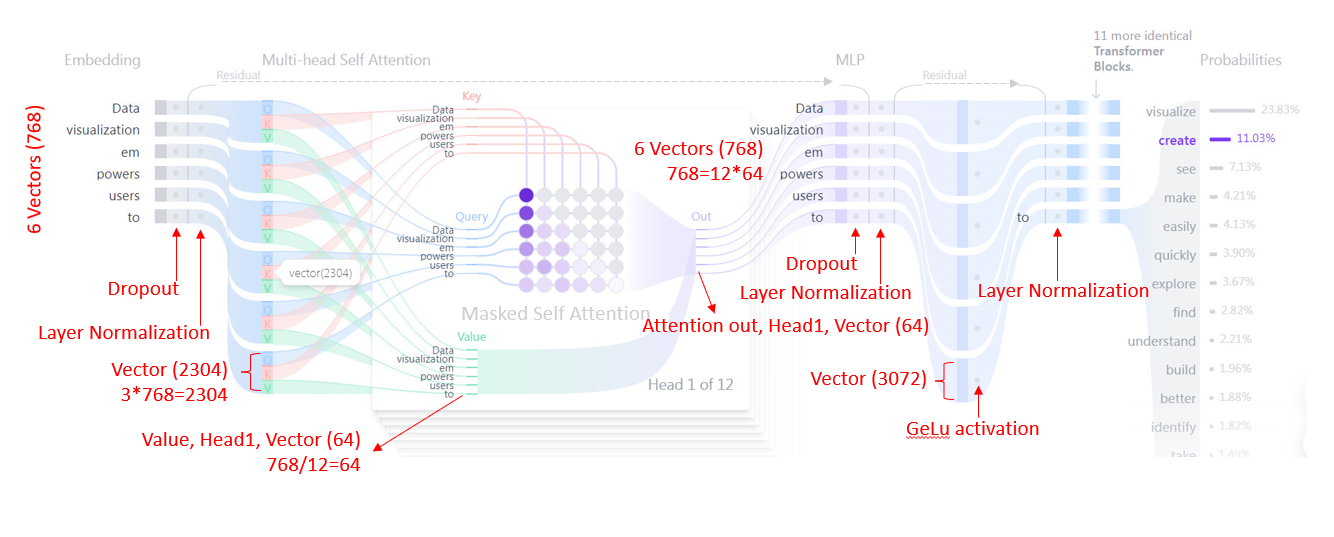

<font color="orange"><h3> Use three different Temperature hyperparameters (smaller than one - one -
Greater than one) </h3> </font>

In [ ]:
# @title Temperature hyperparameter
Temperature = 0.9 # @param {type:"slider", min:0, max:10, step:0.1}

**Hyperparameters & Loss**

In [30]:
batch_size = 32 # how many independent sequences will we process in parallel?
n_context = 256 # what is the maximum context length for predictions?
max_iters = 1500
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
d_model = 768
n_head = 12
n_layer = 12
dropout = 0.0
# ------------

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

**`Head` Class**

This implements a single head of the self-attention mechanism:

In [31]:
class Head(nn.Module):
    """One head of self-attention."""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(d_model, head_size, bias=False)
        self.query = nn.Linear(d_model, head_size, bias=False)
        self.value = nn.Linear(d_model, head_size, bias=False)
        self.register_buffer('mask', torch.triu(torch.ones(n_context, n_context), diagonal=1).float().masked_fill(torch.triu(torch.ones(n_context, n_context), diagonal=1) == 1, float('-inf')))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        k = self.key(x)  # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)

        # Scaled dot-product attention
        wei = (q @ k.transpose(-2, -1)) / (k.size(-1) ** 0.5)  # (B, T, T)
        wei = wei + self.mask[:wei.size(-2), :wei.size(-1)]  # Apply mask
        wei = F.softmax(wei, dim=-1)  # Normalize
        wei = self.dropout(wei)  # Apply dropout

        out = wei @ v  # (B, T, head_size)
        return out

**`MultiHeadAttention` Class**

Combines multiple attention heads:

In [32]:
class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel."""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # Concatenate along head_size
        out = self.proj(out)  # Project back to d_model
        return self.dropout(out)

**`FeedForward` Class**

Implements the feedforward layer with a hidden layer size of $4×d_{model}$:

In [33]:
class FeedForward(nn.Module):
    """A simple feedforward layer."""

    def __init__(self, d_model):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

**`Block` Class**

Combines self-attention and feedforward layers with layer normalization:

In [34]:
class Block(nn.Module):
    """Transformer block: communication followed by computation."""

    def __init__(self, d_model, n_head):
        super().__init__()
        head_size = d_model // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(d_model)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))  # Add & Normalize
        x = x + self.ffwd(self.ln2(x))  # Add & Normalize
        return x

**`TransformerModel` Class**

Defines the entire transformer model and includes the `generate` function to sample from the model:

In [35]:
class TransformerModel(nn.Module):
    """Full Transformer model."""

    def __init__(self):
        super().__init__()
        self.token_embed = nn.Embedding(letters_size, d_model)  # Token embedding
        self.pos_embed = nn.Embedding(n_context, d_model)  # Positional embedding
        self.blocks = nn.Sequential(*[Block(d_model, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(d_model)  # Final layer norm
        self.head = nn.Linear(d_model, letters_size)  # Final projection layer

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embed(idx)  # (B, T, d_model)
        pos_emb = self.pos_embed(torch.arange(T, device=device))  # (T, d_model)
        x = tok_emb + pos_emb  # Combine embeddings
        x = self.blocks(x)  # Apply transformer blocks
        x = self.ln_f(x)  # Final normalization
        logits = self.head(x)  # (B, T, letters_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last n_context tokens
            idx_cond = idx[:, -n_context:]
            # get the predictions
            logits, _ = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply temperature scaling
            logits = logits / temperature
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx

**Temperature Analysis**

Modify the `generate` method or directly vary the `temperature` parameter when sampling:

In [36]:
# Initialize the model and move it to the correct device
model = TransformerModel()
model = model.to(device)

# Print the model parameters for reference
print(f"Model has {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M parameters.")

# Define temperature values for analysis
temperature_values = [0.5, 1.0, 1.5]

# Initial context (start token or similar)
context = torch.zeros((1, 1), dtype=torch.long, device=device)

# Generate and decode text for each temperature value
context = torch.zeros((1, 1), dtype=torch.long, device=device)
for temp in temperature_values:
    print(f"\nGenerated text with temperature {temp}:")
    generated = model.generate(context, max_new_tokens=200, temperature=temp)
    print(decode(generated[0].tolist()))

Model has 85.35M parameters.

Generated text with temperature 0.5:
. 11. 22nd 1813. 27th 1810 3. 50 1813. 40 1809. 07 1789 25th 1812 13 25th 6 100 1809. 30 1st 1797 17 6 1805. 1 1806 3 23rd 160 . 1811 26 1813. 3. 11 4. 1st 1811 12 1811 1805 110 ...of 31 102 1808 1810 1805 3. 1815 1797 24 100 40 1805 178. 140 13th 25th 1815 1810 100 1810 217 1820 1808 1811 1809 1807 3rd 15 13th 13 5 1813. 1789 24th 31 22nd 217 31 1st 000 30 10 24 4. 4th 5 ... 1812. 1808 2 1810 13 1812 1810 102 1813 1815 1810 25th 3. 3 178. 17th 1797 27 3. 1813. 4. 1813. 13 1809 1812. 1810 1809 27th 13th 27th 20 4th 40 24th 1808 4x 1809 217 100 5. ...of 13th 178. 07 .... 1813. 1807 1809 1812. 1820. 13 22nd .... 15 000 1807 .... 1797 1807. 11 3rd 1812. 1820. 2 13 1809. 3. 1810 1813 1815 ... 13 23 25th 1813 1809 130 25 20 .... 2. 3rd 11 11 2 26 17th 40 15 13th 31 110 1809. 4 4 140 1811 130 4th 1 1808 5 12 10 22nd 140 1st ... 140

Generated text with temperature 1.0:
. 10 11 140 13th 100 11 4. 3. 1807. 18th 1811 2. .... 22 

# Part B

### Introduction to Transfer Learning

**Transfer learning** is a machine learning technique where a model trained on one task is adapted or fine-tuned to perform a different but related task. Instead of training a model from scratch, transfer learning leverages the knowledge gained from a source domain (pre-training) and applies it to a target domain (fine-tuning). This approach is particularly beneficial when the target domain has limited labeled data, as it reduces training time and improves model performance by building on learned features from the source domain.

In computer vision, transfer learning often involves using pre-trained models on large-scale datasets (like ImageNet) and fine-tuning them for specific tasks such as object detection, image classification, or segmentation.



### Problem Definition: Noisy Bird Classification Using Self-Supervised Learning and Fine-Tuned Swin Transformer

---

#### **Background**
The task of classifying images of birds into predefined categories is a fundamental problem in computer vision with applications in biodiversity monitoring, conservation, and ornithology research. The challenge becomes more complex when working with **noisy datasets**, where:
1. **Unlabeled data** is abundant but lacks annotations.
2. **Labeled data** is limited and may include class imbalances or variability in image quality.

A robust classification model must leverage the unlabeled data effectively while generalizing well to the labeled data for accurate predictions.

---

#### **Objective**
To develop an efficient pipeline for bird image classification by addressing the following key challenges:
1. Utilize **unlabeled data** through self-supervised learning (SSL) to pre-train the model on a rotation-prediction task.
2. Fine-tune the pre-trained model on a **limited labeled dataset** for the final classification task.

The primary aim is to maximize classification accuracy on the labeled dataset by exploiting self-supervised pre-training.

---

#### **Scope**
The problem consists of two distinct but interlinked tasks:
1. **Self-Supervised Learning (SSL):** Train a Swin Transformer model to predict the rotation angle (0°, 90°, 180°, 270°) applied to unlabeled images, enabling the model to learn generalizable image features.
2. **Fine-Tuning:** Transfer the learned features to a supervised classification task, fine-tuning the model on the labeled dataset for classifying bird species.

This approach ensures that the model extracts meaningful features from the unlabeled dataset, which helps improve performance on the labeled dataset.

---

#### **Challenges**
1. **Unlabeled Data Utilization:** How to effectively use the large volume of unlabeled images for meaningful feature extraction.
2. **Limited Labeled Data:** Mitigating overfitting while fine-tuning on a relatively small labeled dataset.
3. **Feature Representation:** Leveraging the Swin Transformer architecture, which has proven effective for visual tasks but requires adaptation for SSL.
4. **Evaluation and Visualization:** Measuring the model's performance effectively and ensuring interpretability through visualizations.

---

### Transfer Learning in This Problem

In this problem, transfer learning is implemented in two key stages:

#### 1. **Self-Supervised Pre-Training (Source Task)**
   - **Objective**: Pre-train the Swin Transformer model on a **self-supervised learning (SSL) task** using unlabeled bird images.
   - **SSL Task**: The model is trained to predict the rotation angle (0°, 90°, 180°, 270°) applied to the input images. This task forces the model to learn general visual features, such as edges, textures, and patterns, which are useful for image understanding.
   - **Importance for Transfer Learning**:
     - Since the dataset is unlabeled, this step leverages self-supervision to extract meaningful features from the data without requiring manual annotations.
     - These learned features serve as a strong initialization point for downstream tasks, reducing the need for extensive labeled data.

---

#### 2. **Fine-Tuning on Labeled Dataset (Target Task)**
   - **Objective**: Fine-tune the pre-trained Swin Transformer model on a labeled dataset to classify bird images into specific categories.
   - **Transfer Process**:
     - The model’s pre-trained weights from the SSL stage are loaded and adapted to a new classification head designed for the target task (bird species classification).
     - The fine-tuning process adjusts the model parameters to specialize in the labeled dataset while preserving general features learned during pre-training.
   - **Importance**:
     - Fine-tuning builds upon the robust feature representations learned in the SSL stage, leading to faster convergence and improved accuracy on the labeled dataset.
     - This approach effectively addresses the challenge of having limited labeled data by leveraging the unlabeled dataset for pre-training.


---

#### **Results**
1. **Self-Supervised Learning (SSL):**
   - Achieved a steady decrease in rotation prediction loss over epochs, indicating successful feature learning.

2. **Fine-Tuning:**
   - Improved classification accuracy on labeled data due to the transfer of robust feature representations from the SSL stage.
   - Visualized class predictions for randomly selected samples to verify correctness and interpretability.

3. **Visualization and Metrics:**
   - Provided detailed loss and accuracy plots for both SSL and fine-tuning stages.
   - Demonstrated the model's predictions alongside actual labels for qualitative evaluation.


---


### Benefits of Transfer Learning in This Problem
1. **Improved Generalization**: Pre-training helps the model learn domain-specific features (e.g., bird shapes, patterns, and textures) that enhance performance on the target task.
2. **Reduced Overfitting**: Fine-tuning on the labeled dataset starts with strong initial features, reducing the risk of overfitting, especially given the small size of the labeled dataset.
3. **Efficient Training**: By reusing pre-trained weights, training time and computational costs are significantly reduced compared to training from scratch.


In [37]:
!gdown 1-5t1u5UuqUbiqXcggA-QsMzoS6kpnXMz

Downloading...
From: https://drive.google.com/uc?id=1-5t1u5UuqUbiqXcggA-QsMzoS6kpnXMz
To: /content/Noisy_birds.zip
100% 7.98M/7.98M [00:00<00:00, 16.2MB/s]


In [38]:
!unzip -qo Noisy_birds.zip -d ./Noisy_birds/

In [39]:
!mkdir /content/Noisy_birds/labeled

In [40]:
!mv /content/Noisy_birds/budgie /content/Noisy_birds/labeled
!mv /content/Noisy_birds/canary /content/Noisy_birds/labeled
!mv /content/Noisy_birds/duckling /content/Noisy_birds/labeled
!mv '/content/Noisy_birds/rubber duck' /content/Noisy_birds/labeled

In [41]:
import os
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from transformers import SwinForImageClassification, SwinConfig

In [42]:
data_path = "/content/Noisy_birds"
labeled_path = os.path.join(data_path, "labeled")
unlabeled_path = os.path.join(data_path, "unlabeled")

batch_size = 2
epochs_ssl = 10
epochs_ft = 10
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
class RandomRotationFixed:
    '''
    A custom data augmentation utility designed to apply random rotations to an image.
    '''
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, img):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(img, angle)

In [44]:
ssl_transform = transforms.Compose([
    RandomRotationFixed([0, 90, 180, 270]),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


ft_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [45]:
class RotationDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, img) for img in os.listdir(data_dir)]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = transforms.ToPILImage()(plt.imread(image_path))

        # Randomly select one value from the list [0, 90, 180, 270]
        angle = random.choice([0, 90, 180, 270])

        # Rotate the image by the chosen angle
        rotated_image = transforms.functional.rotate(image, angle)

        # Map list [0, 90, 180, 270] to [0, 1, 2, 3] as class indices
        label = [0, 90, 180, 270].index(angle)

        if self.transform:
            rotated_image = self.transform(rotated_image)

        return rotated_image, label

In [46]:
# Create a rotation dataset for SSL
unlabeled_dataset = RotationDataset(data_dir=unlabeled_path, transform=ssl_transform)

# Create a data loader for the unlabeled dataset, set batch size to batch_size, and shuffle
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

# Load image datasets that are organized in a specific folder structure
# where each subfolder corresponds to a class label
labeled_dataset = datasets.ImageFolder(root=labeled_path, transform=ft_transform)

# Split indices into training and validation sets
indices = list(range(len(labeled_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Create subsets of the labeled dataset
train_dataset = Subset(labeled_dataset, train_indices)
val_dataset = Subset(labeled_dataset, val_indices)

# Create data loaders for the train and validation datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

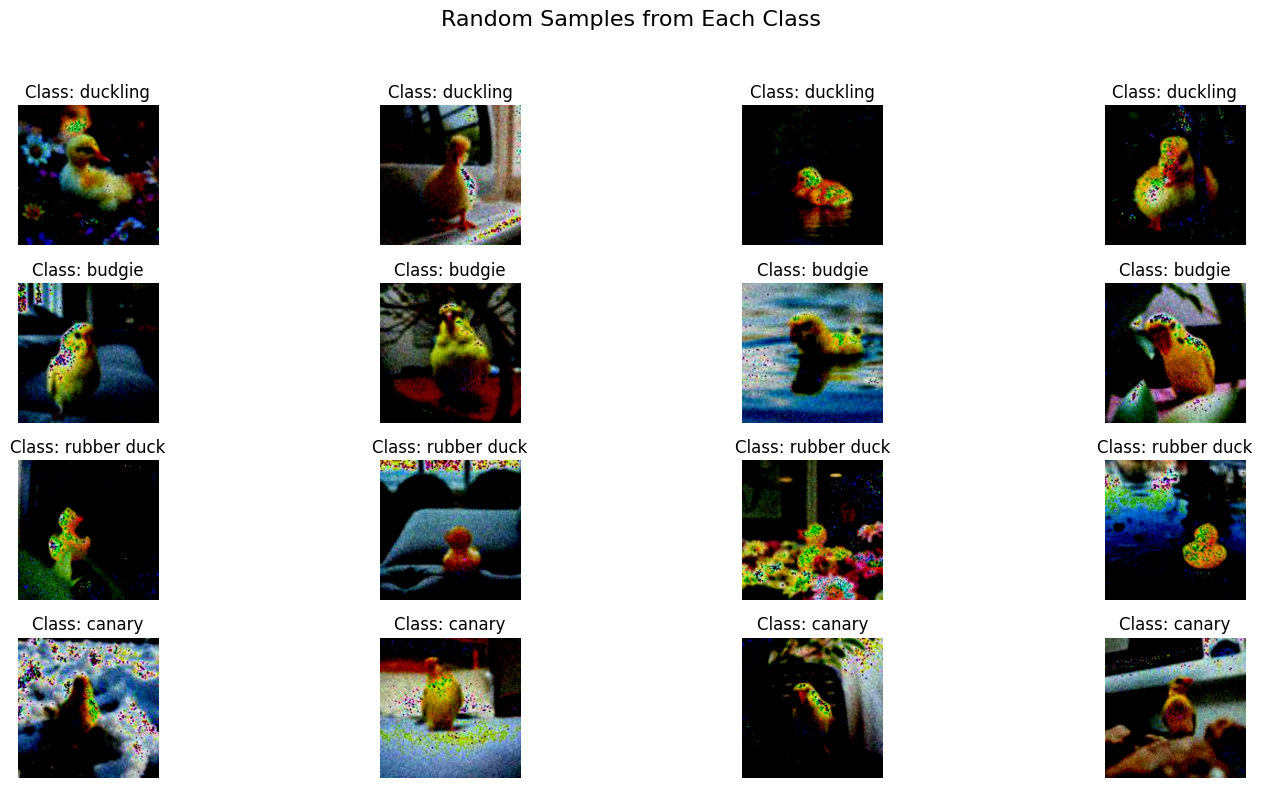

In [47]:
class_to_idx = labeled_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

images_per_class = {}
for idx in range(len(val_dataset)):
    image, label = val_dataset[idx]
    class_name = idx_to_class[label]
    if class_name not in images_per_class:
        images_per_class[class_name] = []
    if len(images_per_class[class_name]) < 4:
        images_per_class[class_name].append((image, class_name))
    if all(len(images) == 4 for images in images_per_class.values()):
        break

fig, axes = plt.subplots(len(images_per_class), 4, figsize=(16, 8))

for row, (class_name, images) in enumerate(images_per_class.items()):
    for col, (image, label) in enumerate(images):
        ax = axes[row, col]
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(f"Class: {label}")
        ax.axis('off')

plt.suptitle("Random Samples from Each Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [48]:
from transformers import SwinForImageClassification, SwinConfig

# Step 1: Create a model configuration
config = SwinConfig()

# Step 2: Initialize the Swin Transformer model for image classification
ssl_model = SwinForImageClassification(config)

# Step 3: Modify the model's final layer to output 4 classes
ssl_model.classifier = nn.Linear(ssl_model.config.hidden_size, 4)

# Step 4: Move the model to the specified device
ssl_model.to(device)

SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [49]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.AdamW(ssl_model.parameters(), lr=learning_rate)

In [50]:
ssl_losses = []

for epoch in range(epochs_ssl):
    # Trigger the training mode
    ssl_model.train()
    epoch_loss = 0.0

    for images, labels in unlabeled_loader:
        # Move images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass (get logits)
        outputs = ssl_model(images).logits

        # Compute loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients

        # Do optimization
        optimizer.step()       # Update parameters

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(unlabeled_loader)
    ssl_losses.append(avg_loss)
    print(f"SSL Epoch [{epoch+1}/{epochs_ssl}], Loss: {avg_loss:.4f}")

SSL Epoch [1/10], Loss: 1.5310
SSL Epoch [2/10], Loss: 1.4443
SSL Epoch [3/10], Loss: 1.4344
SSL Epoch [4/10], Loss: 1.4292
SSL Epoch [5/10], Loss: 1.4110
SSL Epoch [6/10], Loss: 1.4145
SSL Epoch [7/10], Loss: 1.4129
SSL Epoch [8/10], Loss: 1.4067
SSL Epoch [9/10], Loss: 1.3996
SSL Epoch [10/10], Loss: 1.4009


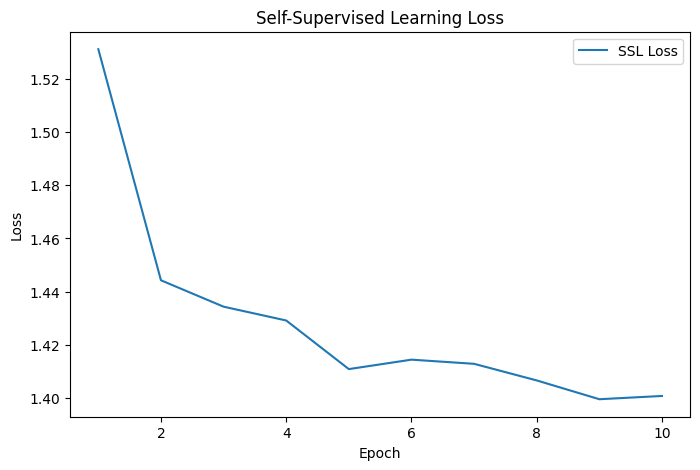

In [51]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs_ssl + 1), ssl_losses, label='SSL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Self-Supervised Learning Loss')
plt.legend()
plt.show()

In [52]:
# Save SSL model
torch.save(ssl_model.state_dict(), "ssl_model.pth")

In [53]:
'''
Like the steps for modifying model for SSL task, define and modify model for classification.
'''

# Load the Swin Transformer configuration for fine-tuning
config = SwinConfig()

# Initialize a new Swin Transformer model for image classification
ft_model = SwinForImageClassification(config)

# Modify the classifier for the number of classes in the labeled dataset
ft_model.classifier = nn.Linear(config.hidden_size, len(class_to_idx))

# Load the pre-trained weights from the SSL model
ft_model.load_state_dict(torch.load("ssl_model.pth"), strict=False)

# Move the fine-tuning model to the specified device
ft_model.to(device)

<ipython-input-53-1fd12ddce0b0>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model.load_state_dict(torch.load("ssl_model.pth"), strict=False)


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0): SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
        

In [54]:
'''
Define the fine-tuning model and initialize it with pre-trained weights trained on SSL task.

Conduct Experiments. To improve performance, you can try the following fine-tuning strategies:

1. Full Fine-Tuning: Fine-tune the entire model, including both the backbone and the classification head.
2. Fine-Tune Only the Classification Head: Freeze the backbone layers and fine-tune only the classification head.
3. Define a New Classification Head: Randomly initialize a new classification head while initializing the backbone from pre-trained weights. Train the new head from scratch.
'''

# Initialize the fine-tuning model with SSL pre-trained weights
ft_model = SwinForImageClassification(config)
ft_model.classifier = nn.Linear(config.hidden_size, len(class_to_idx))
ft_model.load_state_dict(torch.load("ssl_model.pth"), strict=False)
ft_model.to(device)

# Experiment 1: Full Fine-Tuning
def full_fine_tune(model):
    for param in model.parameters():
        param.requires_grad = True  # Unfreeze all layers
    return model

# Experiment 2: Fine-Tune Only the Classification Head
def fine_tune_head_only(model):
    for param in model.parameters():
        param.requires_grad = False  # Freeze all layers
    for param in model.classifier.parameters():
        param.requires_grad = True  # Unfreeze the classifier head
    return model

# Experiment 3: Define a New Classification Head
def redefine_classification_head(model):
    model.classifier = nn.Linear(config.hidden_size, len(class_to_idx))  # Randomly initialize a new head
    for param in model.parameters():
        param.requires_grad = True  # Fine-tune the entire model with the new head
    return model

# Example: Choose one of the strategies
ft_model = full_fine_tune(ft_model)  # or fine_tune_head_only(ft_model) or redefine_classification_head(ft_model)

<ipython-input-54-9938eaade140>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ft_model.load_state_dict(torch.load("ssl_model.pth"), strict=False)


In [55]:
# Define optimizer and loss for fine-tuning
ft_optimizer = torch.optim.Adam(ft_model.parameters(), lr=learning_rate)  # Define optimizer
ft_criterion = nn.CrossEntropyLoss()  # Define loss function

In [56]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs_ft):
    # Training phase
    ft_model.train()  # Set the model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        # Move input images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass (get logits)
        outputs = ft_model(images).logits

        # Compute loss
        loss = ft_criterion(outputs, labels)

        # Backward pass and optimization
        ft_optimizer.zero_grad()  # Zero the parameter gradients
        loss.backward()  # Compute gradients
        ft_optimizer.step()  # Update parameters

        train_loss += loss.item()

        # Compute the accuracy
        _, preds = torch.max(outputs, dim=1)  # Get the predictions
        correct_train += (preds == labels).sum().item()  # Count correct predictions
        total_train += labels.size(0)  # Total samples in this batch

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    ft_model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # No gradient calculation during validation
        for images, labels in val_loader:
            # Move input images and labels to the device
            images, labels = images.to(device), labels.to(device)

            # Forward pass (get logits)
            outputs = ft_model(images).logits

            # Compute loss
            loss = ft_criterion(outputs, labels)

            val_loss += loss.item()

            # Compute the accuracy
            _, preds = torch.max(outputs, dim=1)  # Get the predictions
            correct_val += (preds == labels).sum().item()  # Count correct predictions
            total_val += labels.size(0)  # Total samples in this batch

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs_ft}]:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}, Val Accuracy:   {val_accuracy:.4f}")

Epoch [1/10]:
  Train Loss: 1.4012, Train Accuracy: 0.2667
  Val Loss:   1.3508, Val Accuracy:   0.3000
Epoch [2/10]:
  Train Loss: 1.3797, Train Accuracy: 0.3000
  Val Loss:   1.3421, Val Accuracy:   0.3000
Epoch [3/10]:
  Train Loss: 1.3776, Train Accuracy: 0.2667
  Val Loss:   1.3409, Val Accuracy:   0.3000
Epoch [4/10]:
  Train Loss: 1.3628, Train Accuracy: 0.2833
  Val Loss:   1.3315, Val Accuracy:   0.3000
Epoch [5/10]:
  Train Loss: 1.3602, Train Accuracy: 0.2750
  Val Loss:   1.3340, Val Accuracy:   0.2667
Epoch [6/10]:
  Train Loss: 1.3586, Train Accuracy: 0.2917
  Val Loss:   1.3380, Val Accuracy:   0.3000
Epoch [7/10]:
  Train Loss: 1.4046, Train Accuracy: 0.2583
  Val Loss:   1.4216, Val Accuracy:   0.2667
Epoch [8/10]:
  Train Loss: 1.4167, Train Accuracy: 0.2667
  Val Loss:   1.3548, Val Accuracy:   0.2333
Epoch [9/10]:
  Train Loss: 1.3881, Train Accuracy: 0.2667
  Val Loss:   1.3551, Val Accuracy:   0.2000
Epoch [10/10]:
  Train Loss: 1.3778, Train Accuracy: 0.2167
  Va

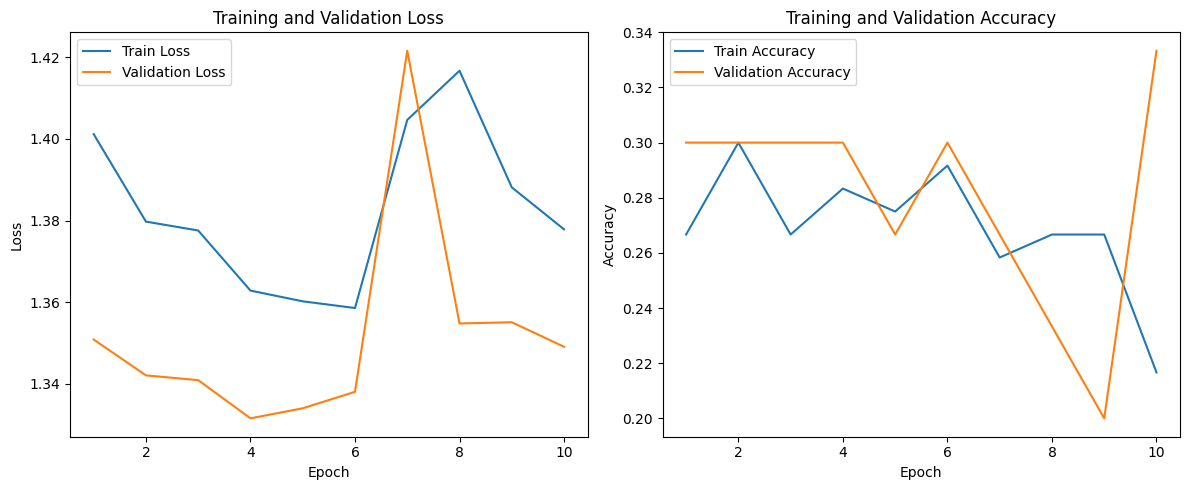

In [57]:
# Plot Fine-Tuning Metrics
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_ft + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs_ft + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_ft + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs_ft + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [58]:
# Save Fine-tuned model
torch.save(ft_model.state_dict(), "fine_tuned_model.pth")

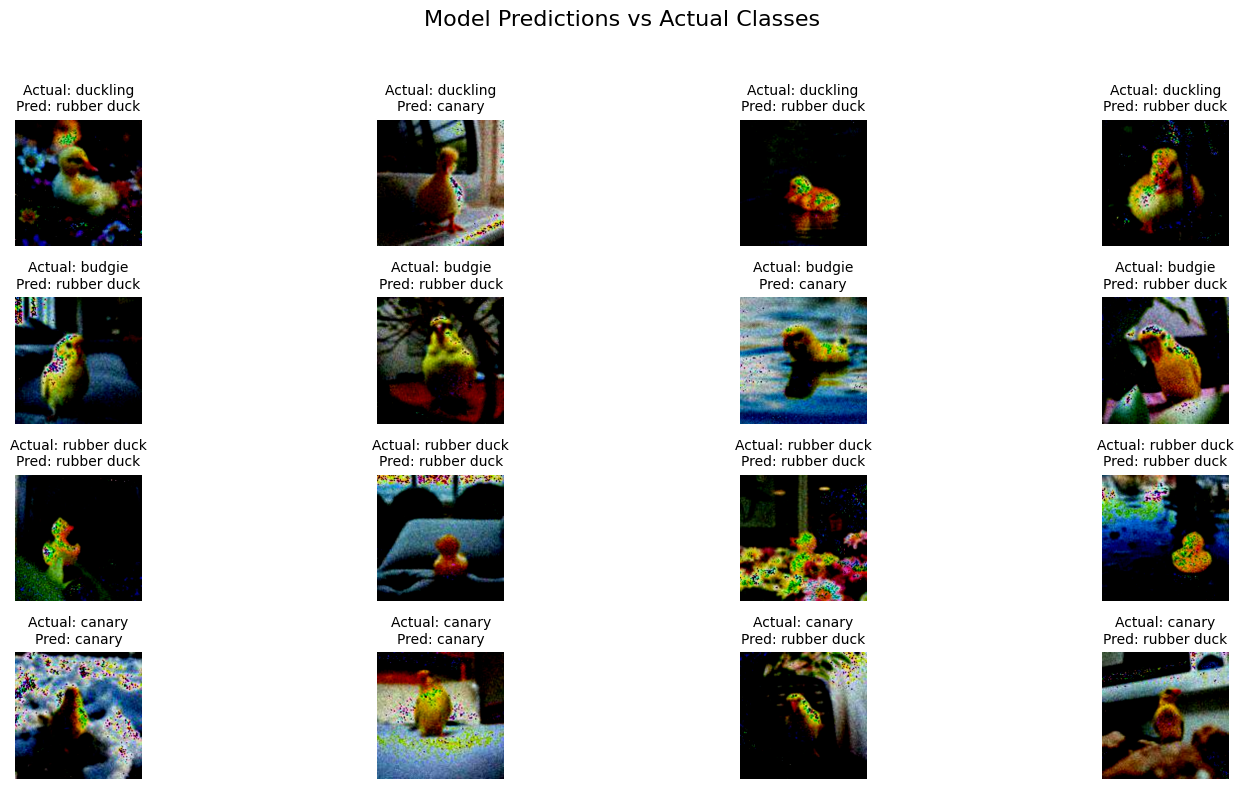

In [59]:
# Evaluate the fine-tuned model on the previously selected images
ft_model.eval()

predicted_classes = {}

with torch.no_grad():
    for class_name, images in images_per_class.items():
        predicted_classes[class_name] = []
        for image, actual_class in images:
            # Move image to device and add batch dimension
            image = image.to(device).unsqueeze(0)  # Add batch dimension

            # Get model prediction (get logits)
            output = ft_model(image).logits
            _, pred_label = torch.max(output, dim=1)  # Get the predicted label
            predicted_class = idx_to_class[pred_label.item()]

            predicted_classes[class_name].append(predicted_class)

fig, axes = plt.subplots(len(images_per_class), 4, figsize=(16, 8))

for row, (class_name, images) in enumerate(images_per_class.items()):
    for col, (image, actual_class) in enumerate(images):
        ax = axes[row, col]

        # Convert image to HWC for visualization
        ax.imshow(image.permute(1, 2, 0))

        pred_label = predicted_classes[class_name][col]
        ax.set_title(f"Actual: {actual_class}\nPred: {pred_label}", fontsize=10)
        ax.axis('off')

plt.suptitle("Model Predictions vs Actual Classes", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()